# Error estimation


In [15]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
import util, config, plots
import ipynbname
import pandas as pd
import numpy as np
import json
import os
import statsmodels as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Confidence intervals using bootstrapping

### Compute a confidence interval by bootstrapping the bitvector

Bootstrapping is a method for estimating the confidence interval of a statistic by resampling the data with replacement. It can be used to construct confidence intervals for a variety of statistics, including means, medians, and proportions.

The following code computes a confidence interval for the proportion of reads with a mutation for a given residue. It does this by bootstrapping the bitvector of reads and computing the proportion of reads with a mutation for each bootstrap sample. The confidence interval is then computed from the bootstrap samples.

Let **N** be the number of bootstrap samples. Let **n** be the number of reads in the bitvector. The confidence interval is computed as follows:
1. Generate **N** bootstrap samples by sampling with replacement from the bitvector.
2. Sort the bootstrap samples in ascending order.
3. The lower bound of the confidence interval is the **2.5**th percentile of the bootstrap samples.
4. The upper bound of the confidence interval is the **97.5**th percentile of the bootstrap samples.

<Figure size 10000x7000 with 0 Axes>

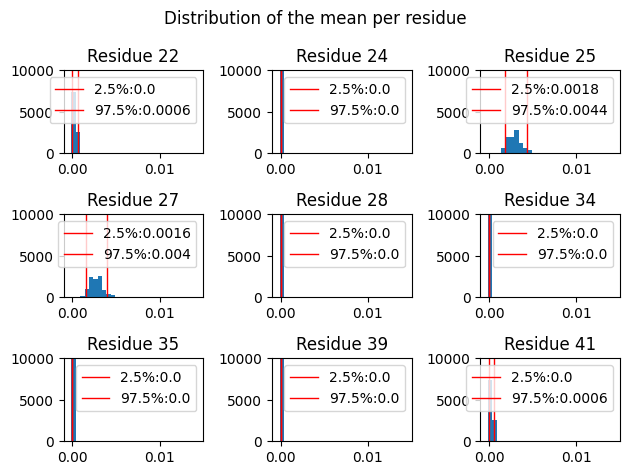

In [16]:
%autoreload 2

N = 10000
n = 5000
# load the data and keep only the first n rows
df = pd.read_orc('/Users/ymdt/src/highthroughputcellularbiology/data/bitvector_examples/3112-O-flank_1=hp6-DB/20-42/0.orc').iloc[:n]

# convert the bitvector to mutation / no mutation
df = df.applymap(lambda x: np.nan if x == 0 else x).applymap(lambda x: 1 if x >= 16 else 0)

# select a random set of 9 residues in the barcode
random_residues_set = np.sort(np.random.choice(np.arange(19,42), 9, replace=False))

# compute the mean for N random samples of size n
means = []
for n in range(N):
    means.append(df.sample(frac=1, replace=True).mean())
means = np.array(means).T

# compute the upper and lower bounds for the mean
bootstrapping_bounds = [[], []]
for i in range(len(means)):
    bootstrapping_bounds[1].append(np.percentile(means[i], 95))
    bootstrapping_bounds[0].append(np.percentile(means[i], 5))

# plot the distribution of the mean for each residue
plots.distribution_of_the_mean(
    means, 
    random_residues_set,
    bootstrapping_bounds
    )

## Confidence intervals using the binomial distribution

By assuming that the number of reads with a mutation is binomially distributed, we can compute the confidence interval analytically. The following code computes the confidence interval using the `statsmodels` library.

The number of reads with a mutation is typically not binomially distributed, but a sum of weighted binomial distributions. This is because since RNA folds into alternative structures, reads from a structure A will have different mutation rates than reads from a structure B. This being said, the maximum variance 

### The Clopper-Pearson method

The `statsmodels` library uses the [Clopper-Pearson](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval) method to compute confidence intervals for binomial proportions.



In [13]:
Clopper_Pearson_bounds = sm.stats.proportion.proportion_confint(df.sum(), len(df), alpha=0.05, method='normal')

## The Wilson score method

The Wilson score method is a method for computing confidence intervals for the proportion of reads with a mutation for a given residue. It is based on the binomial distribution. 

If the reads mutation doesn't properly follow the binomial distribution - for example, if several alternative structures are populated - then the Wilson score method may overestimate the confidence interval.

The `statsmodels` library uses the [Wilson score](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval) method to compute confidence intervals for binomial proportions.

In [14]:
wilson_bounds = sm.stats.proportion.proportion_confint(df.sum(), len(df), alpha=0.05, method='wilson')

## Confidence intervals using the Agresti-Coull method

The Agresti-Coull method is a method for computing confidence intervals for the proportion of reads with a mutation for a given residue. It is based on the binomial distribution. 


If the reads mutation doesn't properly follow the binomial distribution - for example, if several alternative structures are populated - then the Agresti-Coull method may overestimate the confidence interval.

The `statsmodels` library uses the [Agresti-Coull](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Agresti%E2%80%93Coull_interval) method to compute confidence intervals for binomial proportions.



In [ ]:
agresti_coull_bounds = sm.stats.proportion.proportion_confint(df.sum(), len(df), alpha=0.05, method='agresti_coull')

## Compare 

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# fit a linear regression model


### Bootstrapping's leans towards a binomial distribution as N increases

1. Pulling randomly 0s and 1s from a bitvector with ``# of 1 = m`` and ``# of 0 = L-m`` then counting the number of 1 is equivalent to get a sample from the distribution `B(n,m/n)`.

2. The distribution obtained by re-iterating operation `1.` `N` times leans towards a binomial distribution `B(N,m)`.



<Figure size 2000x2000 with 0 Axes>

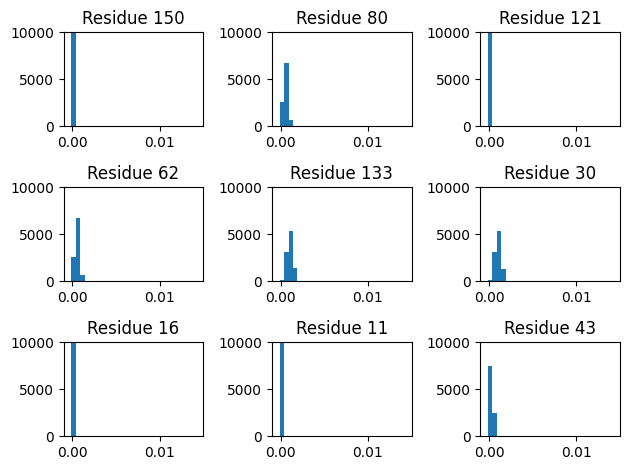

In [37]:
# bootstrap N using binomial law and plot the distribution of the mean
means = []
for n in range(N):
    means.append([l/N for l in np.random.binomial(N, util.compute_mutation_rates(df))])
means = np.array(means).T
plots.distribution_of_the_mean(means, random_residues_set)

## Validate that the bootstrapping method works

,sample,construct,barcode_end,barcode_start,family,flank,num_aligned,secondary_signature,secondary_signature_end,secondary_signature_start,...,mod_bases_A,mod_bases_C,mod_bases_G,mod_bases_N,mod_bases_T,mut_bases,mut_rates,num_of_mutations,poisson_high,poisson_low
0,big_sample_O2,3042-O-flank_1=hp1-DB,151,140,hp1,flank_1,5668,AAGATATTCGAAAGAATATCTT,66,45,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 643, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0...","[0, 1, 0, 643, 1, 0, 1, 0, 2, 1, 3, 0, 1, 0, 0...","[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 3, 0, 1, 0, 0, ...","[0, 1, 0, 643, 1, 0, 1, 0, 2, 1, 3, 0, 1, 0, 0...","[0.0, 0.0001768033946251768, 0.0, 0.1140475345...","[2, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0007, 0.0008, 0.0007, 0.0092, 0.0008, 0.000...","[0.0, 0.0002, 0.0, 0.0086, 0.0002, 0.0, 0.0002..."
1,big_sample_O2,3042-O-flank_1=hp1-DB,151,140,hp1,flank_1,5668,AAGATATTCGAAAGAATATCTT,66,45,...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[1, 2, 1, 0, 0, 0, 0, 2, 3, 0, 1, 0, 1, 2, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 0, ...","[1, 2, 1, 0, 0, 0, 0, 2, 3, 0, 1, 0, 1, 2, 0, ...","[0.000177210703526493, 0.0003540449637103912, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0008, 0.0009, 0.0008, 0.0007, 0.0007, 0.000...","[0.0002, 0.0003, 0.0002, 0.0, 0.0, 0.0, 0.0, 0..."
2,big_sample_O2,3042-O-flank_1=hp1-DB,151,140,hp1,flank_1,5668,AAGATATTCGAAAGAATATCTT,66,45,...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, ...","[2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 1, 2, 1, ...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, ...","[2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 1, 2, 1, ...","[0.00035341933203746247, 0.0, 0.0, 0.0, 0.0, 0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0009, 0.0007, 0.0007, 0.0007, 0.0007, 0.000...","[0.0003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3,big_sample_O2,3042-O-flank_1=hp1-DB,151,140,hp1,flank_1,5668,AAGATATTCGAAAGAATATCTT,66,45,...,"[0, 1]","[0, 0]","[0, 1]","[0, 2]","[0, 0]","[0, 2]","[0.0, 0.00035335689045936394]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0007, 0.0009]","[0.0, 0.0003]"
4,big_sample_O2,3042-O-flank_1=hp1-DB,151,140,hp1,flank_1,5668,AAGATATTCGAAAGAATATCTT,66,45,...,"[0, 0]","[1, 0]","[0, 1]","[1, 1]","[0, 0]","[1, 1]","[0.0001765848490199541, 0.0001772735330615139]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0008, 0.0008]","[0.0002, 0.0002]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,big_sample_O2,3670-O-flank_1=bi12-kshv-DB,151,140,bi12,flank_1,40489,CACC,48,45,...,"[1, 1]","[5, 0]","[1, 2]","[7, 4]","[0, 1]","[7, 4]","[0.00017320301868118274, 9.951734089665124e-05]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0002, 0.0002]","[0.0001, 0.0001]"
5028,big_sample_O2,3670-O-flank_1=bi12-kshv-DB,151,140,bi12,flank_1,40489,CACC,48,45,...,"[0, 0]","[4, 0]","[3, 1]","[7, 11]","[0, 10]","[7, 11]","[0.00017330593449035677, 0.0002727430512508988]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0002, 0.0002]","[0.0001, 0.0001]"
5029,big_sample_O2,3670-O-flank_1=bi12-kshv-DB,151,140,bi12,flank_1,40489,CACC,48,45,...,"[0, 0, 6, 0, 0, 7, 0, 2, 11, 1, 5, 2]","[0, 2, 0, 9, 0, 4, 0, 0, 3, 3, 5, 0]","[2, 1, 0, 0, 4, 1, 3, 1, 0, 0, 0, 4]","[4, 6, 15, 10, 4, 12, 7, 7, 14, 4, 11, 11]","[2, 3, 8, 1, 0, 0, 4, 4, 0, 0, 1, 5]","[4, 6, 15, 10, 4, 12, 7, 7, 14, 4, 11, 11]","[9.936653831822134e-05, 0.00014920548081466192...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...","[0.0001, 0.0001, 0.0002, 0.0001, 0.0001, 0.000..."
5030,big_sample_O2,3670-O-flank_1=bi12-kshv-DB,151,140,bi12,flank_1,40489,CACC,48,45,...,"[2, 4, 3, 0, 4, 1, 0, 4, 2, 1, 0, 1, 0